<a href="https://colab.research.google.com/github/Tavo826/Pix2Pix-Generador-de-flores/blob/main/Pix2Pix_Generador_de_flores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

#Ruta del dataset
PATH = "/content/drive/My Drive/Colab Notebooks/Deep Learning/Dataset pix2pix"

#Ruta de datos de entrada
INPATH = PATH + "/inputFlowers"
#Ruta de datos de salida
OUPATH = PATH + "/targetFlowers"

#Ruta de checkpoints para guardar el entrenamiento de la red
CKPATH = PATH + "/checkpoints"

#Ejecutar comandos de consola para obtener el listado de archivos
#Devuelve todo en una sola columna
imgurls = !ls -1 "{INPATH}"

#Se imprime el contenido de la variable
print(imgurls)


#Se reorganizan los datos para eliminar la organizacipon
#lógica de las imágenes y generar un mejor entrenamiento

#Se trabajan con 500 imágenes
n = 500
#El dataset de entrenamiento es un 8% del n (40)
train_n = round(n*0.08)

#Listado randomizado
#Se genera una copia de las imágenes
randurls = np.copy(imgurls)

#Se reordenan las imágenes
  #eliminar seed
np.random.seed(23) #Genera el mismo ordenamiento aleatorio (según identificación 23)
np.random.shuffle(randurls)

#Se generan dos particiones
#Partición de entrenamiento
tr_urls = randurls[:train_n] #Toma desde el principio de los datos hasta el valor especificado
#Partición de test
ts_urls = randurls[train_n:n] #Toma desde el valor de entrenamiento hasta el número total de datos

#Se imprime la información del dataset
print(len(imgurls), len(tr_urls), len(ts_urls))

['image_00001.jpg', 'image_00002.jpg', 'image_00003.jpg', 'image_00004.jpg', 'image_00005.jpg', 'image_00006.jpg', 'image_00007.jpg', 'image_00008.jpg', 'image_00009.jpg', 'image_00010.jpg', 'image_00011.jpg', 'image_00012.jpg', 'image_00013.jpg', 'image_00014.jpg', 'image_00015.jpg', 'image_00016.jpg', 'image_00017.jpg', 'image_00018.jpg', 'image_00019.jpg', 'image_00020.jpg', 'image_00021.jpg', 'image_00022.jpg', 'image_00023.jpg', 'image_00024.jpg', 'image_00025.jpg', 'image_00026.jpg', 'image_00027.jpg', 'image_00028.jpg', 'image_00029.jpg', 'image_00030.jpg', 'image_00031.jpg', 'image_00032.jpg', 'image_00033.jpg', 'image_00034.jpg', 'image_00035.jpg', 'image_00036.jpg', 'image_00037.jpg', 'image_00038.jpg', 'image_00039.jpg', 'image_00040.jpg', 'image_00041.jpg', 'image_00042.jpg', 'image_00043.jpg', 'image_00044.jpg', 'image_00045.jpg', 'image_00046.jpg', 'image_00047.jpg', 'image_00048.jpg', 'image_00049.jpg', 'image_00050.jpg', 'image_00051.jpg', 'image_00052.jpg', 'image_0005

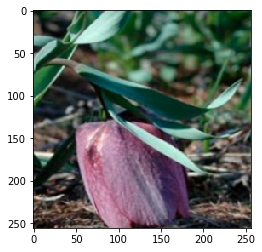

In [ ]:
#Se procede a cargar los datos, utilizando la api datasets de tensorflow
#Se deben especifica las funciones que se quieren aplicar

#Tamaño de las imágenes
IMG_WIDTH = 256
IMG_HEIGHT = 256

#Creando las funciones

#Reescalando las imágenes
def resize(inimg, tgimg, height, width):
  
  inimg = tf.image.resize(inimg, [height,width])
  tgimg = tf.image.resize(tgimg, [height,width])
  
  return inimg, tgimg

#Normalizando las imágenes (se pasa de 0,255 a -1,1)
def normalize(inimg, tgimg):
  
  inimg = (inimg / 127.5) - 1
  tgimg = (tgimg / 127.5) - 1
  
  return inimg, tgimg

#Aumentar datos (aplica transformaciones aleatorias que perturban 
#una imagen para generar otras que ayuden a entrenar a la red)
@tf.function() #Solución para errores de tensorflow 1.x que funcionan en 2.x
def random_jitter(inimg, tgimg):
  
  #Se amplía el tamaño de la imagen a 286x286
  inimg, tgimg = resize(inimg, tgimg, 286, 286)
  
  #Se toman zonas aleatorias de la imagen, aplicando un desplazamiento
  #Se debe realizar la operación en las dos imágenes, por lo tanto
  #se superponen para facilitar el proceso
  #Superposición en el eje 0 (2x286x286)
  stacked_image = tf.stack([inimg,tgimg], axis=0)
  #Recorte aleatorio (#de imágenes, tamaño, canales de color)
  cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
  
  #Recuperando las dos imágenes
  inimg, tgimg = cropped_image[0], cropped_image[1]
  
  #Además se puede girar la imagen, para ampliar el dataser
  #Se utiliza un random flip con un escalar, para decidir si se gira o no la imagen
  if  tf.random.uniform(()) > 0.5:
    inimg = tf.image.flip_left_right(inimg)
    tgimg = tf.image.flip_left_right(tgimg)  
  
  return inimg, tgimg

#Función que carga las imágenes y se aplica siempre el data augmentation
def load_image(filename, augment=True):
  #Se cargan las imágenes desde el directoio de google drive
  #Se decodifica como jpg y se transforma a valores de tipo float
  #Se mantienen las dimensiones de las imágenes pero limita la última dimensión a máximo 3 componentes(RGB)
  inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + '/' + filename)), tf.float32)[..., :3]
  tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUPATH + '/' + filename)), tf.float32)[..., :3]
  
  inimg, tgimg = resize(inimg, tgimg, IMG_HEIGHT, IMG_WIDTH)
  
  if augment:
    inimg, tgimg = random_jitter(inimg, tgimg)
    
  inimg, tgimg = normalize(inimg, tgimg)
  
  return inimg, tgimg

#Se especifica una función de carga de datos y a partir de ahí la api optimiza todo el proceso
#Primero se debe modificar la función de carga de datos ya que depende
#de si se está entrenando o si se hace un test

#Función de entrenamiento
def load_train_image(filename):
  return load_image(filename, True)

#Función de prueba
def load_test_image(filename):
  return load_image(filename, False)

#Se realiza una prueba para comprobar el funcionamiento
plt.imshow(((load_train_image(randurls[0])[1]) + 1) / 2)

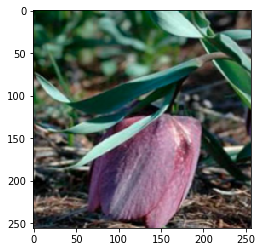

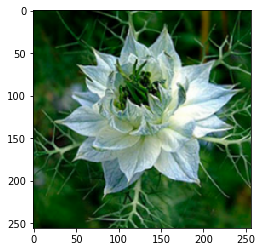

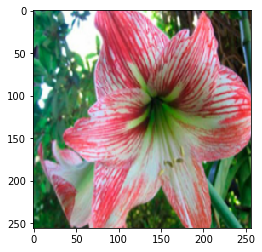

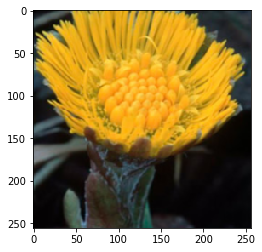

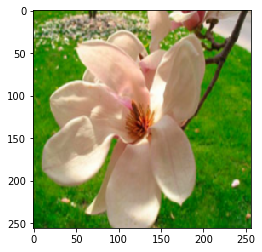

In [ ]:
#Generando el dataset

#Genera un dataset a partir de un listado en específico
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
#Cargando las imágenes a través de un mapeo entre el listado de filenames y las funciones anteriores
#Se puede modificar el número de procesamientos en paralelo
train_dataset = train_dataset.map(load_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#Se distribuyen los datos en diferentes lotes
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
test_dataset = test_dataset.map(load_test_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1)

#Probando el objeto dataset

#5 lotes de tamaño 1
train_dataset.take(5)
#Iterando 5 valores para cada imagen
for inimg, tgimg in train_dataset.take(5):
  plt.imshow(((tgimg[0,...]) + 1) / 2)
  plt.show()

ACA APENAS TERMINA LA PARTE DE CARGA DE DATOS

In [ ]:
#Se empieza a diseñar el sistema Pix2Pix

from tensorflow.keras import *
from tensorflow.keras.layers import *

#Se genera una función para especificar los bloques de 3 capas(paper)
#Capa1: Convolution
#Capa2: BatchNorm
#Capa3: ReLU (activación)

#Todas las convoluciones son de filtros espaciales de 4x4
#Cada convolución tiene un movimiento de 2 pixels
#La capa de BatchNorm no se aplica a la primera capa del encouder
#Los pesos (parámetros) se inicializan con un ruido gaussiano de media 0
#y una desviación estándar de 0.02

#En el encoder se genera una compresión de la imagen
def downsample(filters, apply_batchnorm=True):
  result = Sequential()
  
  #Ruido Gaussiano
  initializer = tf.random_normal_initializer(0, 0.02)
  
  #Capa convolucional
  result.add(Conv2D(filters, 
                    kernel_size=4,                    
                    strides=2,
                    padding="same",
                    kernel_initializer=initializer,
                    use_bias=not apply_batchnorm)) #Parámetro de sesgo de la capa anterior
  
  if apply_batchnorm:
    #Capa de BatchNorm
    result.add(BatchNormalization())
  
  #Capa de activación
  result.add(LeakyReLU())
  
  return result

downsample(64)

In [ ]:
#En el decoder se utilizan 4 capas
#Capa1: Convolution
#Capa2: BatchNorm
#Capa3: Dropout
#Capa4: ReLU (activación)

#Las convoluciones reducen el tamaño de la imagen en la mita

#En el decoder se genera una descompresión de la imagen
def upsample(filters, apply_dropout=False):
  result = Sequential()
  
  #Ruido Gaussiano
  initializer = tf.random_normal_initializer(0, 0.02)
  
  #Capa convolucional
  result.add(Conv2DTranspose(filters, 
                             kernel_size=4,                    
                             strides=2,
                             padding="same",
                             kernel_initializer=initializer,
                             use_bias=False)) #Parámetro de sesgo de la capa anterior
  
  #Capa de BatchNorm
  result.add(BatchNormalization())
  
  if apply_dropout:
    #Capa de Dropout (Desconecta conexiones de manera aleatoria para regular la red)
    result.add(Dropout(0.5))
  
  #Capa de activación
  result.add(ReLU())
  
  return result

upsample(64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


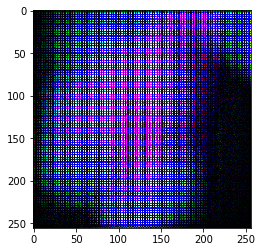

In [ ]:
#Se define el generador U_NET

#Función generadora en la arquitectura
def Generator():
  
  #Capa de entrada, se especifican las dimensiones, None por si la imagen tiene diferentes tamaños
  inputs = tf.keras.layers.Input(shape=[None,None,3])
  
  #Se declara una lista con cada uno de los bloques que conforman la red(paper)
  
  #El tamaño de la imagen se va dividiendo a la mitad
  down_stack = [
      downsample(64, apply_batchnorm=False), #(bs,128,128,64)
      downsample(128),                       #(bs,64, 64, 128)
      downsample(256),                       #(bs,32, 32, 256)
      downsample(512),                       #(bs,16, 16, 512)
      downsample(512),                       #(bs,8,  8,  512)
      downsample(512),                       #(bs,4,  4,  512)
      downsample(512),                       #(bs,2,  2,  512)
      downsample(512),                       #(bs,1,  1,  512)
  ]
  
  #El tamaño de la imagen seva duplicando
  up_stack = [
      upsample(512, apply_dropout=True), #(bs,2,  2,  1024)
      upsample(512, apply_dropout=True), #(bs,4,  4,  1024)
      upsample(512, apply_dropout=True), #(bs,8,  8,  1024)
      upsample(512),                     #(bs,16, 16, 1024)
      upsample(256),                     #(bs,32, 32, 512)
      upsample(128),                     #(bs,64, 64, 256)
      upsample(64),                      #(bs,128,128,128)
  ]
  
  #Última capa: es la que genera la imagen que se está buscando
  
  initializer = tf.random_normal_initializer(0, 0.02)
  
  last = Conv2DTranspose(filters = 3,
                         kernel_size = 4,
                         strides = 2,
                         padding = "same",
                         kernel_initializer = initializer,
                         activation = "tanh")
  
  #Conectando las capas
  
  x = inputs
  #Skip conexion
  s = []
  
  #Para concatenar
  concat = Concatenate()
  
  #Codificador (encoder)
  for down in down_stack:
    #Down va tomando cada una de las capas que hay en el stack
    
    #Resultado de la capa down anterior y se une con la capa actual
    x = down(x)
    
    #Generando las conexiones entre el codificador y el decodificador (U-NET)
    #Se concatenan algunas capas del mismo nivel
    s.append(x)
    
  #Invirtiendo la capa paa concatenar
  s = reversed(s[:-1])  
    
  #Decodificador (decoder)
  for up, sk in zip(up_stack, s):    
    x = up(x)
    
    #Concatenando el resultado
    x=concat([x,sk])    
  
  last = last(x)
  
  #Objeto del modelo
  return Model(inputs=inputs, outputs=last)

#Comprobando que funciona
generator = Generator()

#Si se dese tomar una imagen del train dataset para probar
gen_output = generator(((inimg+1)*255), training=False)
plt.imshow(gen_output[0,...])

#Se genera basura porque no se ha entrenado

TensorShape([1, 16, 16, 1])

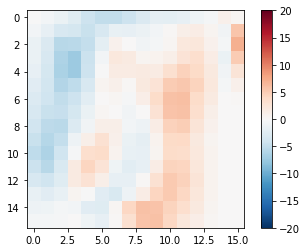

In [ ]:
#Discriminador (utilizan un patchgan: red convolucional que en lugar
#de devolver un escalar para comparar, devuelve una cuadrícula donde
#se evalúan diferentes parches de la imagen original; evalúa por trozos de la imagen)

def Discriminator():
  
  #Está condicionado y tiene acceso a la imagen original de entrada
  ini = Input(shape=[None,None,3], name="input_img")
  gen = Input(shape=[None,None,3], name="gener_img")
  
  #Esto genera 2 imágenes y se deben combinar
  #Se genera un tensor de tamaño (bs x 256 x 256 x 6)
  con = concatenate([ini,gen])
  
  initializer = tf.random_normal_initializer(0, 0.02)
  
  #Se generan las capas del discriminador
  down1 = downsample(64, apply_batchnorm=False)(con)
  down2 = downsample(128)(down1)
  down3 = downsample(256)(down2)
  down4 = downsample(512)(down3)
  
  #La última capa devuelve un solo canal (filtro)
  last = tf.keras.layers.Conv2D(filters=1,
                                kernel_size=4,
                                strides=1,
                                kernel_initializer=initializer,
                                padding="same")(down4)
  
  return tf.keras.Model(inputs=[ini,gen], outputs=last)

discriminator = Discriminator()

#Comprobando con una imagen
disc_out = discriminator([((inimg+1)*255), gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()
disc_out.shape

#Resultado que puede ofrecer el generador

In [ ]:
#Función de coste para unir los resultados de la U_NET (generador) y el discriminador

#Objeto que evalúa el resultado de las imágenes que se van obteniendo
#Se normalizan las imágenes dentro del objeto
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
#Se evalúa el comportamiento del discriminador
def discriminator_loss(disc_real_output, disc_generated_output):
  
  #Diferencias entre los true por ser real y el detectado por el discriminador
  #Evalúa la diferencia entre una imagen real y el resultado idóneo(todos los pixeles son reales para el discriminador)
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
  
  #Diferencias entre los false por ser generado y el detectado por el discriminador
  #Evalúa la diferencia entre una imagen real y el resultado idóneo(todos los pixeles son falsos para el discriminador)
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
  
  total_disc_loss = real_loss + generated_loss
  
  return total_disc_loss

In [ ]:
#Se evalúa el comportamiento del generador
LAMBDA = 100 #Parámetro que regula el grado de error de una componente

#Objetivos:
#Generar una imagen que sea realista
#Conseguir que el error del discriminador se maximice ??

#Parámetros: -Mapa que genera el discriminador -Imagen generada por el generador -Imagen que se esperaba que se generara
def generator_loss(disc_generated_output, gen_output, target):
  
  #Error adversario
  #Diferencia entre el resultado del discriminador al observar la imagen y lo que él quisisera como resultado idóneo
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  
  #mean absolute error
  #Diferencia por pixeles entre la imagen real y la imagen que se generó
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  
  total_gen_loss = gan_loss + (LAMBDA * l1_loss)
  
  return total_gen_loss

ENTRENAMIENTO DEL SISTEMA

In [ ]:
#Se utiliza el sistema Adam para optimizar las funciones

import os

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_prefix = os.path.join(CKPATH, "ckpt")

#Se guardan los estados del entrenamiento del sistema (generador y discriminador)
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#Línea para obtener el último checkpoint guardado en drive (Restaura los estados del sistema)
#checkpoint.restore(tf.train.latest_checkpoint(CKPATH)).assert_consumed()

In [ ]:
#Evalua el comportamiento del modelo generador durante el entrenamiento

def generate_images(model, test_input, tar, save_filename=False, display_imgs=True):
  
  #Se le pasan imágenes del set de pruebas
  prediction = model(test_input, training=True)
  
  #Se guardan las imágenes en un directorio
  if save_filename:
    tf.keras.preprocessing.image.save_img(PATH + '/output/' + save_filename + '.jpg', prediction[0,...])
    
  plt.figure(figsize=(10,10))
  
  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']
  
  if display_imgs:
    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      #Getting the pixel values between [0,1] to plot it
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
      
  plt.show()

In [ ]:
#Implementación de todos los módulos y optimización
@tf.function()
def train_step(input_image, target):
  
  #Objeto que permite acceder a los gradientes y optimizar los pesos (back propagation)
  with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:
  
    #Se llama al generador y se le ingresa el garabato de la flor
    #La imagen se comprime por el encoder y se descomprime por el decoder
    output_image = generator(input_image, training=True)

    #El discriminador observa lo generado por el generador
    #Generador condicional: tiene acceso a la imagen de entrada
    output_gen_discr = discriminator([output_image, input_image], training=True)

    #El discriminador toma la imagen objetivo y observa si es real o no
    output_trg_discr = discriminator([target, input_image], training=True)

    #Discriminator_loss recibe primero el real y luego el generado
    discr_loss = discriminator_loss(output_trg_discr, output_gen_discr)

    #Toma la observación del discriminador a la imagen que había generado, la imagen que había generado y la imagen objetivo
    gen_loss = generator_loss(output_gen_discr, output_image, target)
    
    #Calcular los gradientes de optimizar la función de coste del generador,
    #para optimizar todos los parametros que conforman al generador
    generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
  
    #Lo mismo para el discriminador
    discriminator_grads = discr_tape.gradient(discr_loss, discriminator.trainable_variables)
    
    #OPTIMIZACIÓN
    #Aplicar los gradientes y actualizar los valores de los parámetros en función a estos gradientes
    
    #Para el generador
    generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))
    
    #Para el discriminador
    discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))

In [ ]:
#Definiendo la rutina de entrenamiento
from IPython.display import clear_output

#Se escoge el dataset con el que se quiere trabajar (entrenamiento o test)
def train(dataset, epochs):
  for epoch in range(epochs):
    
    imgi = 0
    for input_image, target in dataset:
      print('epoch' + str(epoch) + ' - train: ' + str(imgi)+ '/' + str(len(tr_urls)))
      imgi+=1
      train_step(input_image, target)
      
      clear_output(wait=True)
    
    imgi = 0
    for inp, tar in test_dataset.take(5):
      #Se guardan imágenes del avance del entrenamiento
      generate_images(generator, inp, tar, str(imgi) + '_' + str(epoch), display_imgs=True)
      imgi += 1
      
    #Saving (checkpoint) the model every 50 epochs
    if (epoch + 1) % 50 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

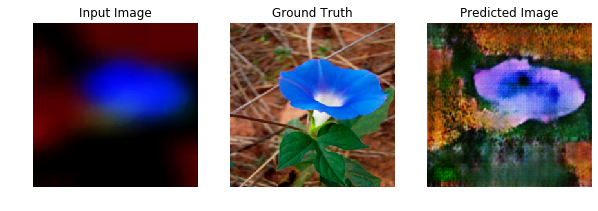

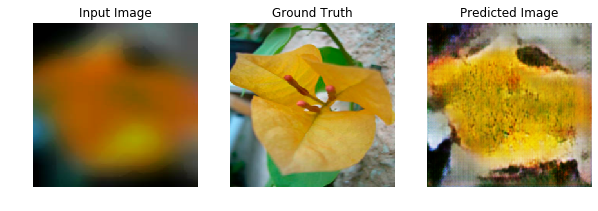

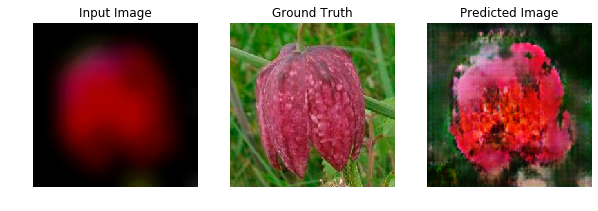

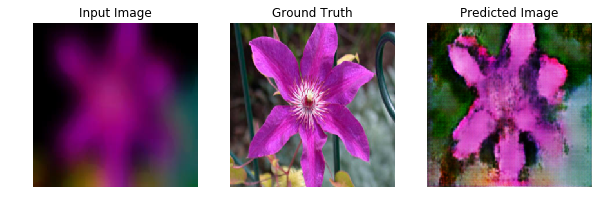

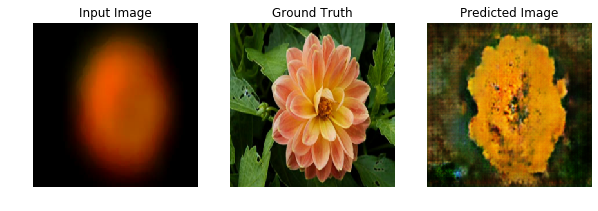

In [ ]:
#Entrenamiento del sistema
train(train_dataset, 100)